In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
import torch
import seaborn as sns
from typing import Sequence

In [34]:
from domino.sdm.gmm import ErrorGMM, GMM

In [109]:
PARAM_A = 3
PARAM_B = 1

def generate_data(n_data, means, covariances, weights, classes, errors):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    X = np.zeros((n_data, n_features))
    y = np.zeros(n_data)
    y_hat = np.zeros(n_data)
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        X[i] = np.random.multivariate_normal(means[k], covariances[k])
        if classes[k] == 1:
            y[i] = np.random.beta(PARAM_A, PARAM_B) > 0.5
            if errors[k] == 1:
                y_hat[i] = np.random.beta(PARAM_B, PARAM_A)
            else:
                y_hat[i] = np.random.beta(PARAM_A, PARAM_B)
        else: 
            y[i] = np.random.beta(PARAM_B, PARAM_A) > 0.5
            if errors[k] == 1:
                y_hat[i] = np.random.beta(PARAM_A, PARAM_B)
            else:
                y_hat[i] = np.random.beta(PARAM_B, PARAM_A)
      
    return X,y, y_hat

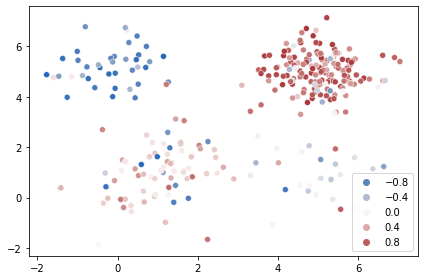

In [110]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 1],
    [1, 1],
    [0, 5],
    [5, 5],
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 8, 1 / 4, 1 / 8, 1 / 2]

# generate data
#np.random.seed(4)
X,y, y_hat = generate_data(300, init_means, init_covariances, init_weights, [0, 1, 0, 1], [0, 0, 1, 1])

sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=y - y_hat,
    palette="vlag"
)#torch.nn.functional.binary_cross_entropy(torch.tensor(y_hat), torch.tensor(y), reduction="none").numpy())
plt.tight_layout()

In [111]:
def plot_contours(data, means, covs, errors, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko', alpha=0.3)

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(
            x_grid, y_grid, z_grid, 10,    
            colors=np.stack(10 * [sns.color_palette("viridis", as_cmap=True)(errors[i])])
        )
    
    plt.title(title)
    plt.tight_layout()

In [112]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture._gaussian_mixture import (
    _estimate_gaussian_covariances_full, _estimate_gaussian_covariances_tied, 
    _estimate_gaussian_covariances_diag, _estimate_gaussian_covariances_spherical,
    _compute_precision_cholesky
)
from scipy.special import logsumexp
from sklearn.mixture._base import _check_X, check_random_state
import sklearn.cluster as cluster

def _estimate_parameters(X, y, y_hat, resp, reg_covar, covariance_type):
    """Estimate the Gaussian distribution parameters.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        The input data array.

    resp : array-like of shape (n_samples, n_components)
        The responsibilities for each data sample in X.

    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.

    covariance_type : {'full', 'tied', 'diag', 'spherical'}
        The type of precision matrices.

    Returns
    -------
    nk : array-like of shape (n_components,)
        The numbers of data samples in the current components.

    means : array-like of shape (n_components, n_features)
        The centers of the current components.

    covariances : array-like
        The covariance matrix of the current components.
        The shape depends of the covariance_type.
    """
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    covariances = {"full": _estimate_gaussian_covariances_full,
                   "tied": _estimate_gaussian_covariances_tied,
                   "diag": _estimate_gaussian_covariances_diag,
                   "spherical": _estimate_gaussian_covariances_spherical
                   }[covariance_type](resp, X, nk, means, reg_covar)

    errors = np.dot(resp.T, np.abs(y - y_hat)) / nk
    return nk, means, covariances, errors


class ErrorGMM(GaussianMixture):
    
    def _initialize_parameters(self, X, y, y_hat, random_state):
        """Initialize the model parameters.

        Parameters
        ----------
        X : array-like of shape  (n_samples, n_features)

        random_state : RandomState
            A random number generator instance that controls the random seed
            used for the method chosen to initialize the parameters.
        """
        n_samples, _ = X.shape

        if self.init_params == 'kmeans':
            resp = np.zeros((n_samples, self.n_components))
            label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
                                   random_state=random_state).fit(X).labels_
            resp[np.arange(n_samples), label] = 1
        elif self.init_params == 'random':
            resp = random_state.rand(n_samples, self.n_components)
            resp /= resp.sum(axis=1)[:, np.newaxis]
        else:
            raise ValueError("Unimplemented initialization method '%s'"
                             % self.init_params)

        self._initialize(X,y, y_hat, resp)

    def _initialize(self, X, y, y_hat, resp):
        """Initialization of the Gaussian mixture parameters.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        resp : array-like of shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances, errors = _estimate_parameters(
            X, y, y_hat, resp, self.reg_covar, self.covariance_type)
        weights /= n_samples

        self.weights_ = (weights if self.weights_init is None
                         else self.weights_init)
        self.means_ = means if self.means_init is None else self.means_init
        self.errors_ = errors
        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type)
        elif self.covariance_type == 'full':
            self.precisions_cholesky_ = np.array(
                [linalg.cholesky(prec_init, lower=True)
                 for prec_init in self.precisions_init])
        elif self.covariance_type == 'tied':
            self.precisions_cholesky_ = linalg.cholesky(self.precisions_init,
                                                        lower=True)
        else:
            self.precisions_cholesky_ = self.precisions_init
    
    def fit(self, X, y, y_hat):
        self.fit_predict(X, y, y_hat)
        return self

    def fit_predict(self, X, y, y_hat):
        X = _check_X(X, self.n_components, ensure_min_samples=2)
        self._check_n_features(X, reset=True)
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not(self.warm_start and hasattr(self, 'converged_'))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.infty
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, y, y_hat, random_state)

            lower_bound = (-np.infty if do_init else self.lower_bound_)

            for n_iter in range(1, self.max_iter + 1):
                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X, y, y_hat)
                self._m_step(X, y, y_hat, log_resp)
                lower_bound = self._compute_lower_bound(
                    log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn('Initialization %d did not converge. '
                          'Try different init parameters, '
                          'or increase max_iter, tol '
                          'or check for degenerate data.'
                          % (init + 1), ConvergenceWarning)

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X, y, y_hat)

        return log_resp.argmax(axis=1)
    
    def _m_step(self, X, y, y_hat, log_resp):
        """M step.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        log_resp : array-like of shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        resp = np.exp(log_resp)
        n_samples, _ = X.shape
        self.weights_, self.means_, self.covariances_, self.errors_ = (
            _estimate_parameters(X, y, y_hat, resp, self.reg_covar,
                                          self.covariance_type))
        self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)

        
    
    def _e_step(self, X, y, y_hat):
        """E step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob_norm : float
            Mean of the logarithms of the probabilities of each sample in X

        log_responsibility : array, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        log_prob_norm, log_resp = self._estimate_log_prob_resp(X, y, y_hat)
        return np.mean(log_prob_norm), log_resp
    
    def _estimate_log_prob_resp(self, X, y, y_hat):
        """Estimate log probabilities and responsibilities for each sample.

        Compute the log probabilities, weighted log probabilities per
        component and responsibilities for each sample in X with respect to
        the current state of the model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob_norm : array, shape (n_samples,)
            log p(X)

        log_responsibilities : array, shape (n_samples, n_components)
            logarithm of the responsibilities
        """
        weighted_log_prob = self._estimate_weighted_log_prob(X, y, y_hat)
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        with np.errstate(under='ignore'):
            # ignore underflow
            log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        return log_prob_norm, log_resp

    def _estimate_weighted_log_prob(self, X, y, y_hat):
        return self._estimate_log_prob(X) + self._estimate_log_weights() +  self._estimate_error_log_prob(y, y_hat)

    def _get_parameters(self):
        return (self.weights_, self.means_, self.covariances_, self.errors_,
                self.precisions_cholesky_)

    def _set_parameters(self, params):
        (self.weights_, self.means_, self.covariances_, self.errors_,
         self.precisions_cholesky_) = params

        # Attributes computation
        _, n_features = self.means_.shape

        if self.covariance_type == 'full':
            self.precisions_ = np.empty(self.precisions_cholesky_.shape)
            for k, prec_chol in enumerate(self.precisions_cholesky_):
                self.precisions_[k] = np.dot(prec_chol, prec_chol.T)

        elif self.covariance_type == 'tied':
            self.precisions_ = np.dot(self.precisions_cholesky_,
                                      self.precisions_cholesky_.T)
        else:
            self.precisions_ = self.precisions_cholesky_ ** 2

    def _n_parameters(self):
        """Return the number of free parameters in the model."""
        return super()._n_parameters() + 2 * self.n_components 
    
    def _estimate_error_log_prob(self, y, y_hat):
        # DCHECK_THIS
        likelihood = np.zeros((len(y), self.n_components))
        likelihood += np.log(1 - self.errors_)
        likelihood += np.expand_dims(y_hat * (1 - y) + (1 - y_hat) * (y), axis=1)
        likelihood += np.log(self.errors_)
        likelihood += np.expand_dims(y_hat * (y) + (1 - y_hat) * (1 - y), axis=1)
        return likelihood

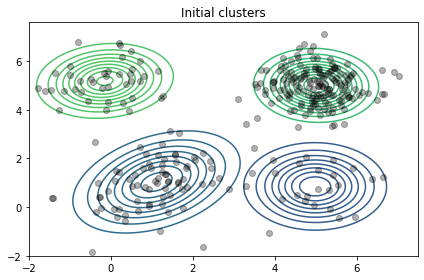

In [113]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
gmm = ErrorGMM(n_components = 4, max_iter = 1000, tol = 1e-4)
gmm.fit(X, y, y_hat)

plot_contours(X, gmm.means_, gmm.covariances_, gmm.errors_, 'Initial clusters')

In [114]:
gmm.errors_

array([0.3507463 , 0.68318446, 0.72657799, 0.29113396])

In [120]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
n_dims = 100
from sklearn.datasets import make_spd_matrix
init_means = np.array([
    np.random.randn(n_dims) * (i +1 ) for i in range(4)]
)

init_covariances = np.array(
    [make_spd_matrix(n_dims)] * 4
)

init_weights = [1 / 8, 1 / 4, 1 / 8, 1 / 2]

# generate data
#np.random.seed(4)
X,y, y_hat = generate_data(300, init_means, init_covariances, init_weights, [0, 1, 0, 1], [0, 0, 1, 1])

In [121]:
gmm = ErrorGMM(n_components = 4, max_iter = 1000, tol = 1e-4)
gmm.fit(X, y, y_hat)

ErrorGMM(max_iter=1000, n_components=4, tol=0.0001)

In [122]:
gmm.errors_

array([0.66354332, 0.66842858, 0.27839262, 0.3209207 ])

In [33]:
gmm.weights[0]

nan